# Trabalho de casa 02: Regressão linear

**Instruções gerais:** Sua submissão deve conter: 
1. Um "ipynb" com seu código e as soluções dos problemas
2. Uma versão pdf do ipynb

Caso você opte por resolver as questões de "papel e caneta" em um editor de $\LaTeX$ externo, o inclua no final da versão pdf do 'ipynb'.

## Exercícios computacionais

**Exercício 1.** Deixamos à sua disposição o dataset ["California Housing"](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html#sklearn.datasets.fetch_california_housing), dividido em treino, teste e validação.
O modelo que você utilizará para aproximar a relação funcional entre as features e as labels é o modelo linear, i.e., $\boldsymbol{y} = X\theta$.
Entretanto, você deve estimar seus parâmetros (minimizando o *mean squared error*) com **dois algoritmos diferentes**.
Uma implementação deve estimar $\theta$ por meio de **Stochastic Gradient Descent (SGD)** e, a outra, por meio de **Ordinary Least Squares (OLS)**, ou seja, utilizar a solução em fórmula fechada vista em aula.

Para o SGD, o ponto inicial deve ser escolhido aleatoriamente e o algoritmo deve parar quando a norma da diferença entre duas estimativas consecutivas de $\theta$ for menor do que um $\varepsilon > 0$ previamente especificado.
Para o experimento a seguir, fixe $\varepsilon$ em um valor pequeno (por exemplo, alguma potência de $1/10$) para a qual o algoritmo convirja no máximo em alguns minutos para uma solução com perda pequena.

Para diferentes tamanhos de minibatch (por exemplo $\{2^{j}: 1 \leq j \leq 7\}$), plote um gráfico representando o valor da perda $ L(\hat{\theta}) = \frac{1}{n} \lVert X \hat{\theta} - \mathbf{y} \rVert^{2}$ no conjunto de validação em função do número de epochs. Mostre também o valor ótimo obtido com OLS. Comente os resultados e o efeito tamanho do minibatch, e.g., no tempo de treinamento. Reporte valores nos conjuntos de treino, validação e teste.

In [11]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split


SEED = 42
np.random.seed(SEED)


features, labels = fetch_california_housing(return_X_y=True)
features_train, features_test, labels_train, labels_test = train_test_split(
    features, labels, test_size=0.25
)
features_train, features_validation, labels_train, labels_validation = train_test_split(
    features_train, labels_train, test_size=0.25
)

Inicialmente, vamos implementar a função auxiliar de MSE

In [13]:
# Definir a função de perda (Mean Squared Error)
def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

Vamos primeiro implementar o método SGD.

In [25]:
# stochastic gradient descent (SGD) regressor

class SGD():
    def __init__(self, learning_rate=0.1**8, batch_size=128, epsilon=0.1**7):
        self.theta = None
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.epsilon = epsilon
        self.loss = []
        self.thetas = []

    # a função fit é usada para treinar o modelo
    def fit(self, X, y):
        # adiciono viés
        X = np.hstack((np.ones((X.shape[0], 1)), X)) # adiciona uma coluna de 1s
        self.theta = np.random.normal(scale=0.0001, size=(X.shape[1], 1)) # inicializa os pesos
        y = y.reshape(-1, 1) # transforma y em um vetor coluna

        epoch = 0
        criteria = np.inf # inicializa o critério de parada
        while criteria > self.epsilon: # enquanto o critério de parada não for atingido
            # get random batch from data
            batch = np.random.choice(X.shape[0], self.batch_size) # escolhe aleatoriamente os índices dos exemplos
            X_batch = X[batch] # seleciona os exemplos
            y_batch = y[batch] # seleciona os rótulos

            # calculate gradient
            gradient = 2 * X_batch.T.dot(X_batch.dot(self.theta) - y_batch) / self.batch_size

            # update theta
            self.theta = self.theta - (self.learning_rate * gradient)
            self.thetas.append(self.theta)

            # check stopping criteria
            if epoch > 0:
                criteria = np.linalg.norm(self.theta - self.theta_old)
            self.theta_old = self.theta

            error = np.mean((X_batch.dot(self.theta) - y_batch)**2)/X_batch.shape[0]
            self.loss.append(error)
            epoch += 1

    # afunção predict é usada para fazer previsões com o modelo treinado        
    def predict(self, X):
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        return X.dot(self.theta) 

Agora podemos calcular o MSE para o conjunto de validação e teste.

In [47]:
sgd = SGD()

sgd.fit(features_train, labels_train)
sgd.predict(features_validation)
media = mean_squared_error(labels_validation, sgd.predict(features_validation))
print("MSE: ", media)

MSE:  1.4145839018047441


Vamos visualizar o comportamento do MSE em função da época.

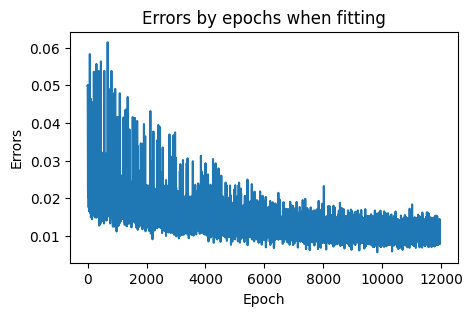

In [48]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 3))
plt.plot(sgd.loss)
plt.xlabel('Epoch')
plt.ylabel('Errors')
plt.title('Errors by epochs when fitting')
plt.show()

Note que conforme a época avança, o MSE se torna ligeiramente mais estável, convergindo pra algo entre $0.005$ e $0.02$. Agora, vamos avaliar o comportamento da função perda diante de diferentes tamanhos de minibatch.

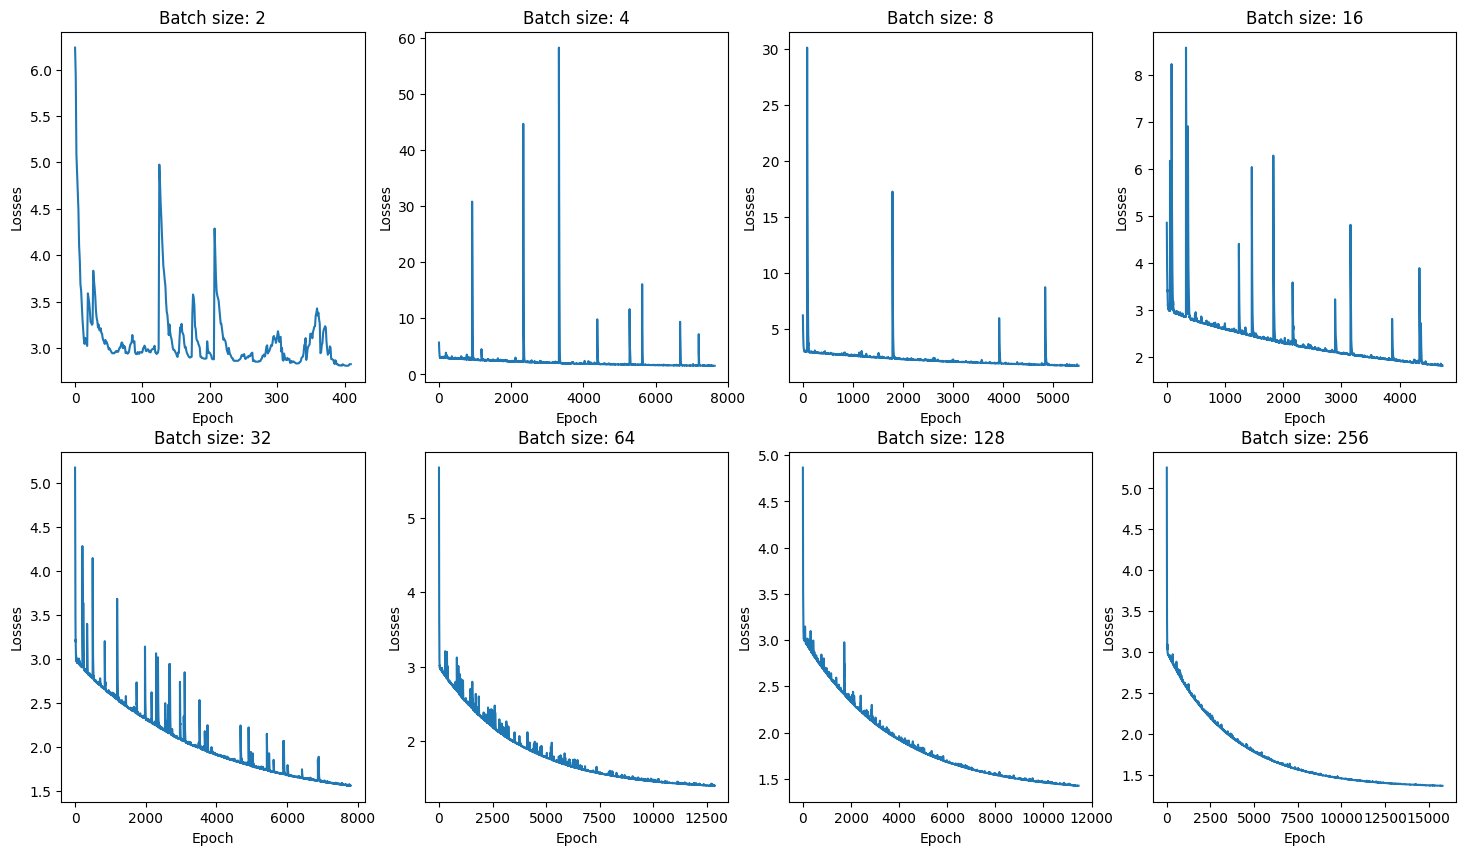

In [64]:
# make figure
figure = plt.figure(figsize=(18, 10))
for i in range(1,9):
    sgd = SGD(batch_size=2**i)
    sgd.fit(features_train, labels_train)
    errors = []
    # add bias
    X = np.hstack((np.ones((features_validation.shape[0], 1)), features_validation))
    for theta in range(len(sgd.thetas)):
        error = np.mean((X.dot(sgd.thetas[theta]) - labels_validation.reshape(-1, 1)) ** 2)
        errors.append(error)
    ax = figure.add_subplot(2, 4, i)
    ax.plot(errors)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Losses')
    ax.set_title(f'Batch size: {2**i}')
plt.show()

Note que conforme a época avança, o MSE se torna ligeiramente mais estável conforme o tamanho do minibatch aumenta. Além desse conportamento podemos observar que a função perda se torna suave conforme o tamanho do minibatch aumenta. No entanto, existem picos de perda mesmo pra valores altos da época (observável para batch size = 32, por exemplo). É ainda destacável que conforme o tamanho do minibatch aumenta, o tempo de treinamento também aumenta consideravelmente.

Finalmente, podemos implementar o método OLS.

In [66]:
class OLS():
    def __init__(self):
        self.theta = None

    def fit(self, X, y):
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        self.theta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)

    def predict(self, X):
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        return X.dot(self.theta)

Testando no conjunto de validação e teste, temos o seguinte resultado.

In [71]:
ols = OLS()
ols.fit(features_train, labels_train)
media = mean_squared_error(labels_validation, ols.predict(features_validation))
print("MSE: ", media)

MSE:  0.5356253807287028


Comparando com o valor real:

In [73]:
ols = OLS()
ols.fit(features_train, labels_train)
media = mean_squared_error(labels_test, ols.predict(features_test))
print("MSE: ", media)

MSE:  0.542084954078024


**Exercício 2.** Agora, utilizando ainda o mesmo dataset da questão anterior, você deve implementar uma **Rede RBF** com função de base Gaussiana (veja as notas de aula).
Para os centróides, utilize o output de um modelo de clusterização por K médias, por meio da função que disponibilizamos, como a seguir:

In [84]:
def k_means_factory(n_clusters: int) -> KMeans:
    return KMeans(n_clusters=n_clusters, n_init="auto")

k_means_model = k_means_factory(n_clusters=2)
dumb_data = np.array(
    [[1, 2],
     [1, 4],
     [1, 0],
     [10, 2],
     [10, 4],
     [10, 0]]
)
k_means_model.fit(dumb_data)
cluster_centers = k_means_model.cluster_centers_
print(cluster_centers) # Shape (n_clusters, n_features)

[[ 1.  2.]
 [10.  2.]]


Para determinar o melhor valor de $k$ para o algoritmo de clusterização, treine o modelo (usando a fórmula de OLS) com diferentes valores e escolha o que possuir o menor erro de validação. Faça um gráfico mostrando o valor do erro de validação para diferentes valores de $k$. Mostre também a performance do modelo escolhido no conjunto de teste. Compare com o modelo linear simples da questão anterior. Discuta os resultados.

Para definir o valor do hiper-parâmetro $\gamma$, use a seguinte heurística --- que pode ser achado no livro "Neural Networks", por Simon Haykin:

$$
\gamma = \frac{1}{d_\text{max}^2},
$$

onde $d_\text{max}$ é a maior distância entre um par de centróides. Note que o valor costuma mudar para $k$'s diferentes.


**Resposta.** Primeiramente, vamos implementar a rede RBF.

In [92]:

class RBF():
    def __init__(self, n_clusters=3, gamma=1):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.cluster_centers = None
        self.theta = None

    def ols(self, X, y):
        self.theta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
        return self.theta


    def fit(self, X, y):
        # add bias
        X = np.hstack((np.ones((X.shape[0], 1)), X))

        # cluster centers
        k_means_model = k_means_factory(n_clusters=self.n_clusters)
        k_means_model.fit(X)
        self.cluster_centers = k_means_model.cluster_centers_

        # calculate max distance
        max_dist = np.max(np.linalg.norm(self.cluster_centers - self.cluster_centers[:, None], axis=-1))
        # calculate gamma
        self.gamma = 1/max_dist**2
        # calculate rbf
        rbf = np.exp(-self.gamma * np.linalg.norm(X[:, None] - self.cluster_centers, axis=-1)**2)

        # train with OLS
        y = y.reshape(-1, 1)
        self.theta = self.ols(rbf, y)


    def predict(self, X):
        # add bias
        X = np.hstack((np.ones((X.shape[0], 1)), X))

        # calculate rbf
        rbf = np.exp(-self.gamma * np.linalg.norm(X[:, None] - self.cluster_centers, axis=-1)**2)
        return rbf.dot(self.theta)

Agora, vamos aplicar o algoritmo de clusterização por K médias pra o conjunto de treino.

In [119]:
ks = []
for k in range(2, 25):
    rbf = RBF(n_clusters=k)
    rbf.fit(features_train, labels_train)
    ks.append(np.mean((rbf.predict(features_validation) - labels_validation)**2))


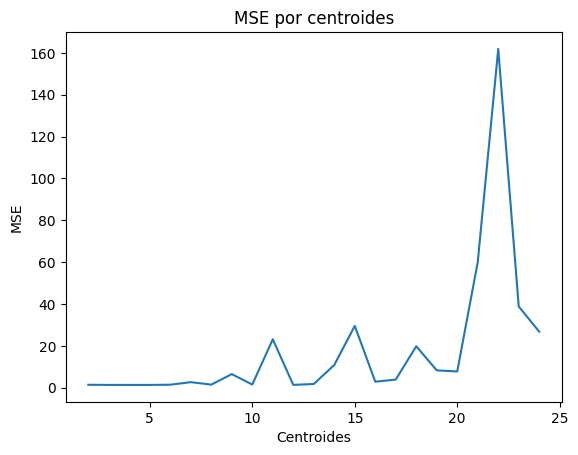

<Figure size 500x300 with 0 Axes>

In [120]:
plt.plot(range(2, 25), ks)
plt.xlabel('Centroides')
#plt.xticks([2, 4, 6, 8, 10, 12, 14, 16, 18, 20])
plt.ylabel('MSE')
plt.title('MSE por centroides')
#redefinir tamanho da imagem
plt.figure(figsize=(5, 3))
plt.show()

Observe que o MSE é razoavelmente estável para valores menores de $k$. No entanto, para valores maiores de $k$, o MSE tende a aumentar. Vamos escolher o valor de $k$ que minimiza o MSE:

In [122]:
#escolha do menor MSE para o número de centroides
print("MSE: ", min(ks), "Centroides: ", ks.index(min(ks))+2)

MSE:  1.324843463135861 Centroides:  5


Fazendo o mesmo para o conjunto de teste, temos:

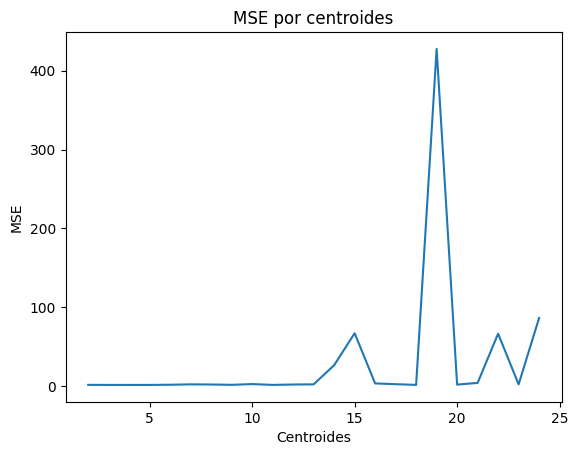

<Figure size 500x300 with 0 Axes>

In [121]:
ks = []
for k in range(2, 25):
    rbf = RBF(n_clusters=k)
    rbf.fit(features_train, labels_train)
    ks.append(np.mean((rbf.predict(features_test) - labels_test)**2))

plt.plot(range(2, 25), ks)
plt.xlabel('Centroides')
#plt.xticks([2, 4, 6, 8, 10, 12, 14, 16, 18, 20])
plt.ylabel('MSE')
plt.title('MSE por centroides')
#redefinir tamanho da imagem
plt.figure(figsize=(5, 3))
plt.show()


Aqui, podemos observar que novamente o modelo se sai melhor com um valor de $k$ menor, enquanto para valores de $k$ mais altos o MSE se torna cada vez menos estábilizado. 
Para $k=5$,o MSE obtido se encontra abaixo

In [123]:
#mse obtido com k=5
print("MSE: ", min(ks), "Centroides: ", ks.index(min(ks))+2)


MSE:  1.324843463135861 Centroides:  5


Comparando com o modelo linear simples, temos que o modelo RBF não se saiu melhor que o modelo linear simples. Isso pode ser devido ao fato de que o modelo RBF é mais sensível a hiperparâmetros, como o valor de $k$ e $\gamma$. Além disso, o modelo RBF é mais complexo e, portanto, mais suscetível a overfitting.

# Exercícios de "papel e caneta"

**Exercício 1.** Deixe que $X \in \mathbb{R}^{N\times D}$, $c>0$ e $I$ denote a matriz identidade de dimensão $N$.
 Mostre que $X^\intercal X + c I$ possui inversa.

**Resposta.** Para que a matriz seja invertível, é necessário que todos os seus autovalores sejam não nulos, ou melhor dizendo, que o produto de seus autovalores seja não nulo. Vamos fazer uma analise passo-a-passo das propriedades da matriz do enunciado.\
Primeiramente, note que a matriz $X^\intercal X$ é simétrica e positiva semi-definida. Para demonstrar que é positiva semi-definida, note que para todo vetor $v \in \mathbb{R}^D$, temos que $v^\intercal X^\intercal X v = (Xv)^\intercal Xv = \lVert Xv \rVert^2 \geq 0$. 
A matriz diagonal $cI$ é claramente simétrica positiva definida para $c>0$.\
Agora, vamos analisar a soma dessas duas matrizes e verificar se a mesma é simétrica e positiva definida. Para isso, é necessário que $y^T(X^TX + cI)y > 0$.
Se aplicarmos distributividade, temos que $$y^T(X^TX + cI)y = y^TX^TXy + cy^Ty$$
A primeira parte $ y^T(X^TX)y $ vimos anteriormente que é positiva semi-definida. A segunda parte é claramente positiva definida por se tratar de uma matriz diaginal e $c>0$. Portanto, a soma dessas duas matrizes é simétrica e positiva definida, o que implica que a mesma possui todos os autovalores positivos - não nulos, como queríamos - e, portanto, é invertível.


**Exercício 2.** Deixe que $X \in \mathbb{R}^{N\times D}$ seja uma matriz contendo os exemplos de treinamento (um por linha) e que $y\in \mathbb{R}^N$ seja um vetor coluna dos outputs observados para cada vetor de input em suas linhas. Na aula, derivamos a solução de mínimos quadrados ordinários (OLS). Use o mesmo raciocínio para resolver achar o vetor de pesos ${\theta}$ que minimiza:
 
$$ \|X \theta - y\|_2^2 + c \|\theta\|_2^2,$$

onde $c>0$ é uma constante.

**Resposta.** POdemos derivar a expressão do enunciado e igualar a zero, encontrando assim os pesos que minimizem a função. Para isso, vamos primeiro reescrever a expressão do enunciado como produtos internos. 
$$ \|X \theta - y\|_2^2 + c \|\theta\|_2^2 = <X\theta - y,X\theta - y> + c<\theta,\theta>$$
pelas propriedades de derivação de produto interno, temos que 
$$\frac{d}{d\theta}<X\theta - y,X\theta - y> = <X, X\theta - y> +<X\theta - y, X>$$
$$\frac{d}{d\theta}<X\theta - y,X\theta - y> =<X, X\theta - y> +<X, X\theta - y>$$
Reescrevendo em notações matriciais,
$$\frac{d}{d\theta}<X\theta - y,X\theta - y> 2X^T(X\theta - y)$$
De forma semelhante, temos que
$$\frac{d}{d\theta}c<\theta,\theta> = 2c\theta$$
Daí, igualando a zero, temos que
$$2X^T(X\theta - y) + 2c\theta = 0$$
$$X^TX\theta - X^Ty + c\theta = 0$$
$$X^TX\theta + c\theta = X^Ty$$
$$X^TX\theta + cI\theta = X^Ty$$
Pela primeira questão, validada a inversa de $X^TX + cI$, temos que
$$\theta = (X^TX + cI)^{-1}X^Ty$$
é o vetor de pesos que minimiza a função.

**Exercício 3.** Em algumas situações, temos muito mais features que amostras ($D \gg N$). Esse tipo de cenário é comum, e.g., na análise de dados genômicos. Nesse caso, costumam existir infinitas combinações lineares das features que expressam o vetor de saídas $y$. Portanto, precisamos de algum critério para escolher um deles. Uma abordagem possível, é escolher o vetor de pesos $\theta$ que possua menor norma L2.
Com isso em mente, derive a solução que minimiza $\|\theta\|_2^2$ e respeita $X \theta = y$. Assuma que as linhas de $X$ são linearmente independentes.

**Resposta.** Para resolver esse problema, vmos utilizar o método de Lagrange. O método  é utilizado quando queremos otimizar uma função de várias variáveis, sujeita a uma ou mais restrições. A ideia básica é introduzir multiplicadores de Lagrange para converter o problema de otimização com restrições em um problema de otimização sem restrições.\
Suponha que temos a função objetivo $$( f(x_1, x_2, ..., x_n) )$$ que queremos maximizar ou minimizar, sujeita a uma ou mais restrições $$( g_1(x_1, x_2, ..., x_n) = c_1, g_2(x_1, x_2, ..., x_n) = c_2, ..., g_m(x_1, x_2, ..., x_n) = c_m )$$.
Para resolver esse problema com o método de Lagrange, formulamos a função Lagrangeana $L$, que é dada por:
$$[ L(x_1, x_2, ..., x_n, \lambda_1, \lambda_2, ..., \lambda_m) = f(x_1, x_2, ..., x_n) + \lambda_1(g_1(x_1, x_2, ..., x_n) - c_1) + \lambda_2(g_2(x_1, x_2, ..., x_n) - c_2) + ...  ]$$
onde $( \lambda_1, \lambda_2, ..., \lambda_m )$ são os multiplicadores de Lagrange associados às restrições.\
Em seguida, calculamos os gradientes de $L$ em relação a todas as variáveis $( x_1, x_2, ..., x_n, \lambda_1, \lambda_2, ..., \lambda_m )$ e igualamos cada gradiente a zero. Isso nos dá um conjunto de equações chamadas de equações de Lagrange.\
No nosso caso, temos que a função objetivo é $\|\theta\|_2^2$ e a restrição é $X \theta = y$. Portanto, a função Lagrangeana é dada por:
$$ L(\theta, \lambda) = \|\theta\|_2^2 + \lambda(X \theta - y)$$
onde $\lambda$ é o multiplicador de Lagrange.\
Agora, vamos calcular o gradiente de $L$ em relação a $\theta$ e igualar a zero. Temos que
$$\nabla_\theta L = 2\theta + \lambda X = 0$$
$$\theta = -\frac{1}{2}\lambda X$$
Agora, vamos calcular o gradiente de $L$ em relação a $\lambda$ e igualar a zero. Temos que
$$\nabla_\lambda L = X\theta - y = 0$$
$$X\theta = y$$
Substituindo o valor de $\theta$ na equação acima, temos que
$$X(-\frac{1}{2}\lambda X) = y$$
$$-\frac{1}{2}X^TX\lambda = y$$
$$X^TX\lambda = -2y$$
Assumindo que $X^TX$ é invertível- o que é verdadeiro se as linhas de $X$ são linearmente independentes - temos que
$$\lambda = -(X^TX)^{-1}2y$$
Substituindo o valor de $\lambda$ na equação $\theta = -\frac{1}{2}\lambda X$, temos que
$$\theta = X^T(X^TX)^{-1}y$$
é o vetor de pesos que minimiza a função.